In [4]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

from matplotlib import cm
from scipy import integrate
from astropy.coordinates import SkyCoord
from utils.stringUtils import EventCalculator, ExperimentExpectationsCalculator
# from itertools import combinations
# from math import factorial

%matplotlib inline

In the [Chernoff et al 2020 paper](https://ui.adsabs.harvard.edu/abs/2020MNRAS.491..596C/abstract) equation 12 gives the microlensing rate per star per second: 

$\frac{\Gamma}{N_\star} = \int_0^D dr' dl \left(\frac{dn}{dl}\right)'\langle \frac{dA_\perp}{dt} \rangle$.

I use $\langle \frac{dA_\perp}{dt} \rangle = 0.2 lc$.

I take $\left(\frac{dn}{dl}\right)'$ to be $\frac{1}{l}\mathcal{F}(r')\,\mathcal{G}\,\left(\frac{dn}{d\ln{l}}\right)_\text{base}$, as in Equation 3, which invokes clustering via $\mathcal{F}$. In their paper, $\mathcal{G} = 10^2$ as stated in the first paragraph on page 598, and equation 1 states that:

$\left(\frac{dn}{d\ln{l}}\right)_\text{base} = 1.15 \times 10^{-6} \frac{x}{(1+x)^{5/2}} \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \text{kpc}^{-3}$,

where $\mu_{-13} = \frac{G \mu}{c^2} \times 10^{13}$, $x = \frac{l}{l_g}$, $l_g = 0.0206 \, \Gamma_{50} \, \mu_{-13}$ pc, and $\Gamma_{50} = f_{0.2} = \alpha_{0.1} = 1$. The clustering enhancement 

$\mathcal{F}(r) = \max \left(\beta(\mu)\mathcal{E}(r), 1\right) = \max\left(\beta(\mu) \frac{\rho_{DM}(r)}{\Omega_{DM} \rho_{\text{crit}}}, 1\right)$ 

is defined in the second paragraph on the right side of page 599. $\max$ is used to ensure that $\mathcal{F} \geq 1$ always. The functional form of $\beta(\mu)$ is given in Appendix F of [Chernoff and Tye's 2018 paper](https://arxiv.org/pdf/1712.05060.pdf). $\mathcal{E} = \frac{\rho_{DM}(r)}{\Omega_{DM} \rho_{\text{crit}}}$ is defined in equation 5: 

$ \rho_{\text{MW - M31}} = \begin{cases}
\frac{A}{r^{9/4}} & 0 < r < r_1 \\ 
\frac{2^{3/4}A}{(B-r)^{9/4}} & r_1 < r < B
\end{cases} $

where $A = 1.15 \times 10^9 M_\odot / \text{kpc}^{3/4}$, $r_1 = 345$ kpc, and $B = 780$ kpc. I use $\Omega_{DM} = 1/4$ and $\rho_{\text{crit}} = 3 H_0^2/8\pi G$. Finally, I place the observer 8 kpc from the Milky Way center and the source 8 kpc in front of the center of M31, as indicated in table 1 of the 2020 paper.

Combining all this gives:

$\frac{\Gamma}{N_\star} = \int_8^{772}dr' \int_0^\infty dl \, \frac{1}{l}\, \mathcal{F}(r) \, \mathcal{G}\, 1.15 \times 10^{-6} \, \frac{x}{(1+x)^{5/2}} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \text{kpc}^{-3}  lc$

Cancelling the factors of $l$ and using $dl = l_g dx$ gives:

$\frac{\Gamma}{N_\star} = \int_8^{772}dr' \int_0^\infty dx l_g \, c \, \mathcal{F}(r) \, \mathcal{G}\, 1.15 \times 10^{-6} \, \frac{x}{(1+x)^{5/2}} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \text{kpc}^{-3} $.

the $x$ integral gives:

$\int_0^\infty dx \frac{x}{(1+x)^{(5/2)}} = 4/3$.

Finally we have

$\frac{\Gamma}{N_\star} = l_g \, c \, 
\mathcal{G} \, 1.15 \times 10^{-6} \, \frac{4}{3} \, \frac{f_{0.2}\alpha_{0.1}^{1/2}}{(\Gamma_{50}\mu_{-13})^{3/2}} \, \int_8^{772} dr \mathcal{F}(r) \, \text{kpc}^{-3} $

In [5]:
# def filterTupleToVector(filterTuple, nFilters):
#     z = np.zeros(nFilters)
#     np.put(z, filterTuple, 1)
#     return z

# def multinomialPDF(x, p):
#     n = x.sum()
#     return (factorial(n) / (np.prod([factorial(xx) for xx in x]))) * np.prod(np.power(p, x))

In [6]:
planarSourceSkyCoordinates = EventCalculator.relationalPositionToSkyCoordinates([780 * u.kpc, 
                                                                                 SkyCoord("00h42m44.3s", 
                                                                                          "+41d16m9s")],
                                                                                8 * u.kpc, "plane", 0.1 * u.kpc)
behindSourceSkyCoordinates = EventCalculator.relationalPositionToSkyCoordinates([780 * u.kpc, 
                                                                                 SkyCoord("00h42m44.3s", 
                                                                                          "+41d16m9s")],
                                                                                8 * u.kpc, "behind", 0.1 * u.kpc)
centerToCenterSkyCoordinates = [779.999 * u.kpc, SkyCoord("00h42m44.3s", "+41d16m9s")]

planarConfig = dict(tensions = np.logspace(-15, -8, num=8),
                    curlyG = 1e2,
                    dmHaloA = 1.15e9 * u.solMass / u.kpc**(3/4),
                    dmHaloC = 2**(3/4),
                    dmHaloR1 = 345 * u.kpc,
                    sourceSkyCoordinates = planarSourceSkyCoordinates
                    )

behindConfig = planarConfig.copy()
behindConfig["sourceSkyCoordinates"] = behindSourceSkyCoordinates

centerToCenterConfig = planarConfig.copy()
centerToCenterConfig["sourceSkyCoordinates"] = centerToCenterSkyCoordinates

planarEventCalculator = EventCalculator(planarConfig)
behindEventCalculator = EventCalculator(behindConfig)
centerToCenterEventCalculator = EventCalculator(centerToCenterConfig)

nSteps = 100000
planarEventCalculator.calculate(nSteps=nSteps)
behindEventCalculator.calculate(nSteps=nSteps)
centerToCenterEventCalculator.calculate(nSteps=nSteps)

# Values from table C1 of the 2020 paper
tObs = 1 * u.yr
tableC1PlanarResults = np.array([9.66e-6, 2.64e-6, 5.36e-7, 8.11e-8, 
                                 9.14e-9, 7.67e-10, 1.51e-12, np.nan])
tableC1BackResults = np.array([2.46e-3, 6.72e-4, 1.36e-4, 2.07e-5, 
                                 2.33e-6, 1.95e-7, 1.52e-12, np.nan])

Here I plot the enhancement factors along the line of sight just to make sure everything looks reasonable.

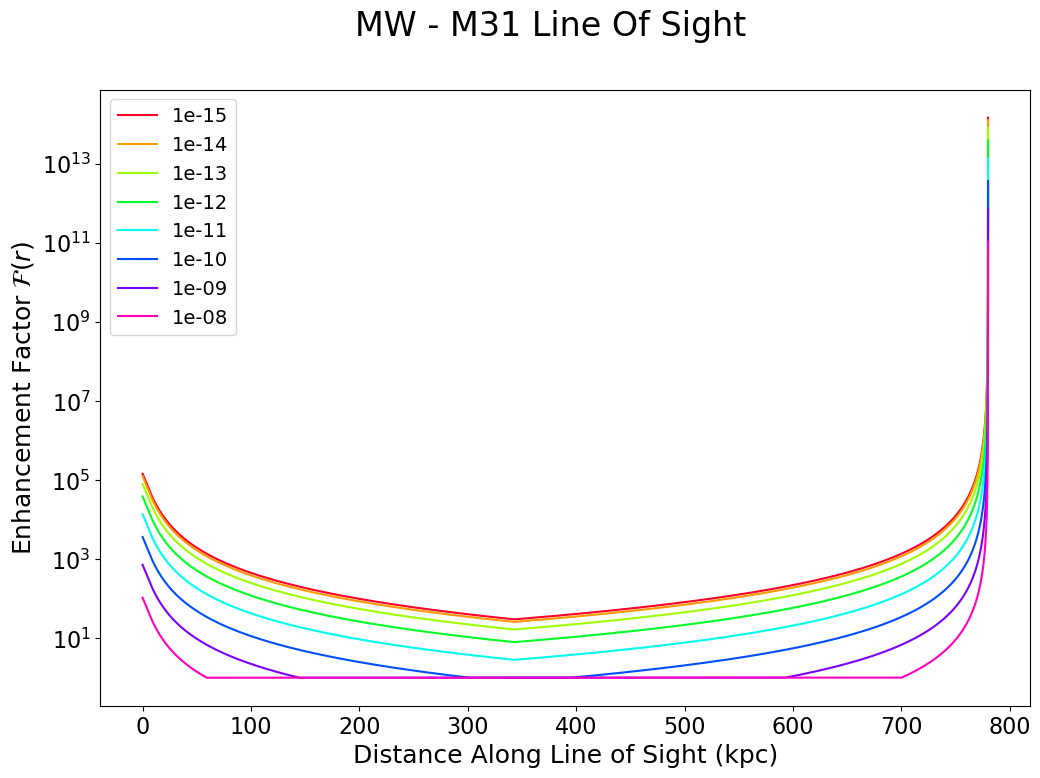

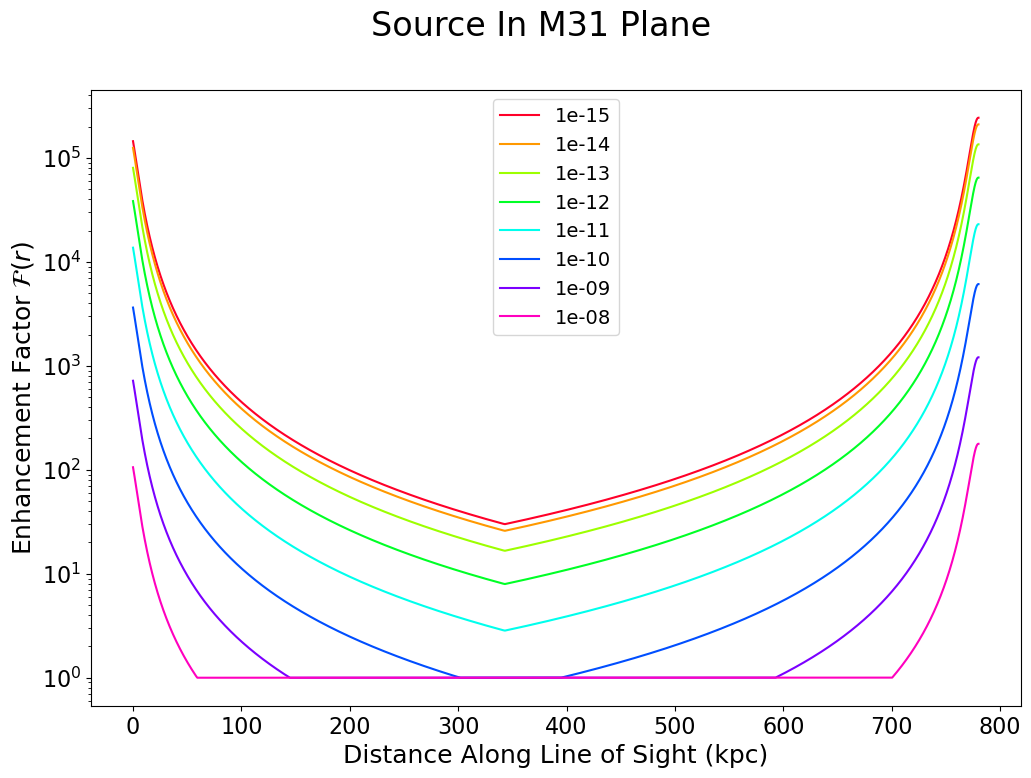

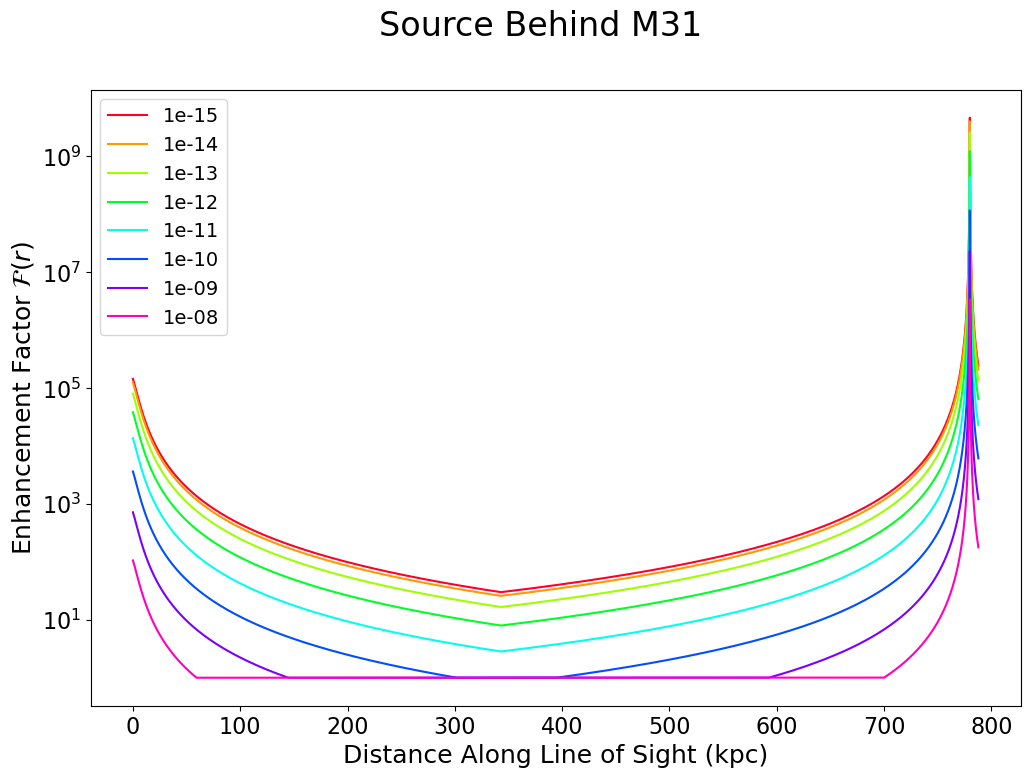

In [7]:
centerToCenterEventCalculator.plotEnhancement(title="MW - M31 Line Of Sight")
planarEventCalculator.plotEnhancement(title="Source In M31 Plane")
behindEventCalculator.plotEnhancement(title="Source Behind M31")

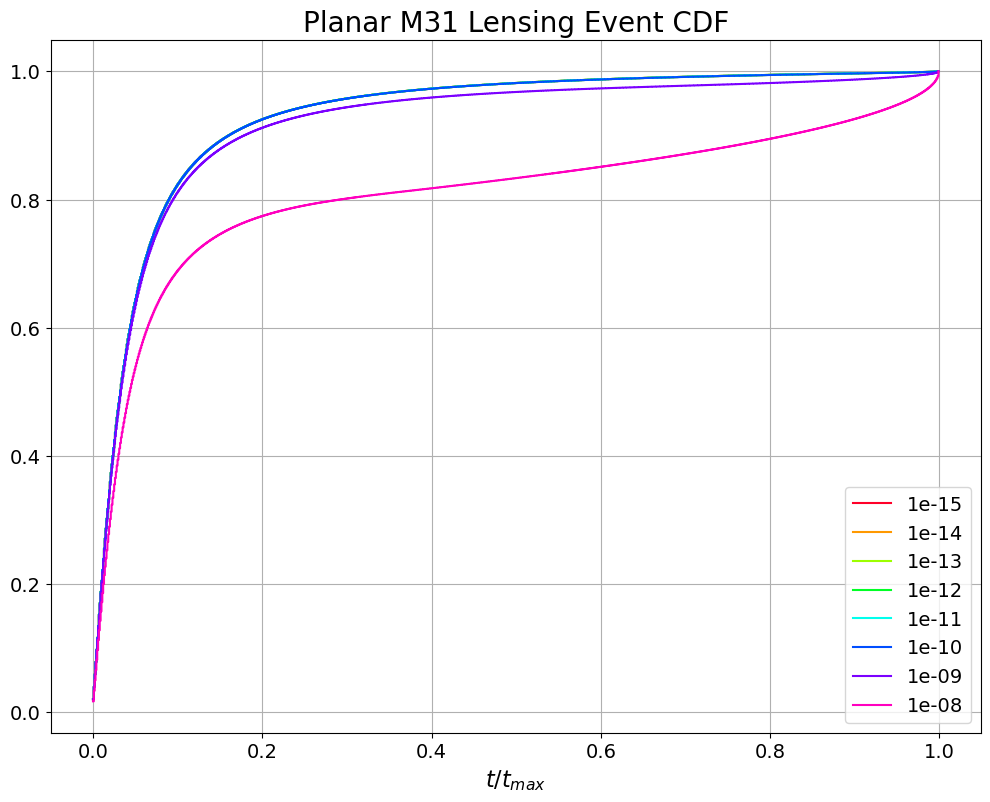

In [8]:
planarLensingTimeCDF, planarLensingTimeBins = planarEventCalculator.computeLensingTimeCDF()
planarMaxTimes = planarEventCalculator.computeMaximumLensingTimes()

colors = cm.gist_rainbow(np.linspace(0, 1, num=len(planarEventCalculator.tensions)))

fig, ax = plt.subplots(figsize=(12, 9))

for i in range(len(planarLensingTimeCDF)):
    ax.plot(planarLensingTimeBins[i][:-1]/planarMaxTimes[i], planarLensingTimeCDF[i], 
            label=f"{planarEventCalculator.tensions[i]}", color=colors[i], ds="steps-post")
    
ax.tick_params(labelsize=14)
ax.set_xlabel(r"$t/t_{max}$", fontsize=16)
ax.legend(loc="lower right", fontsize=14)
ax.set_title("Planar M31 Lensing Event CDF", fontsize=20)
ax.grid(visible=True)
plt.show(fig)

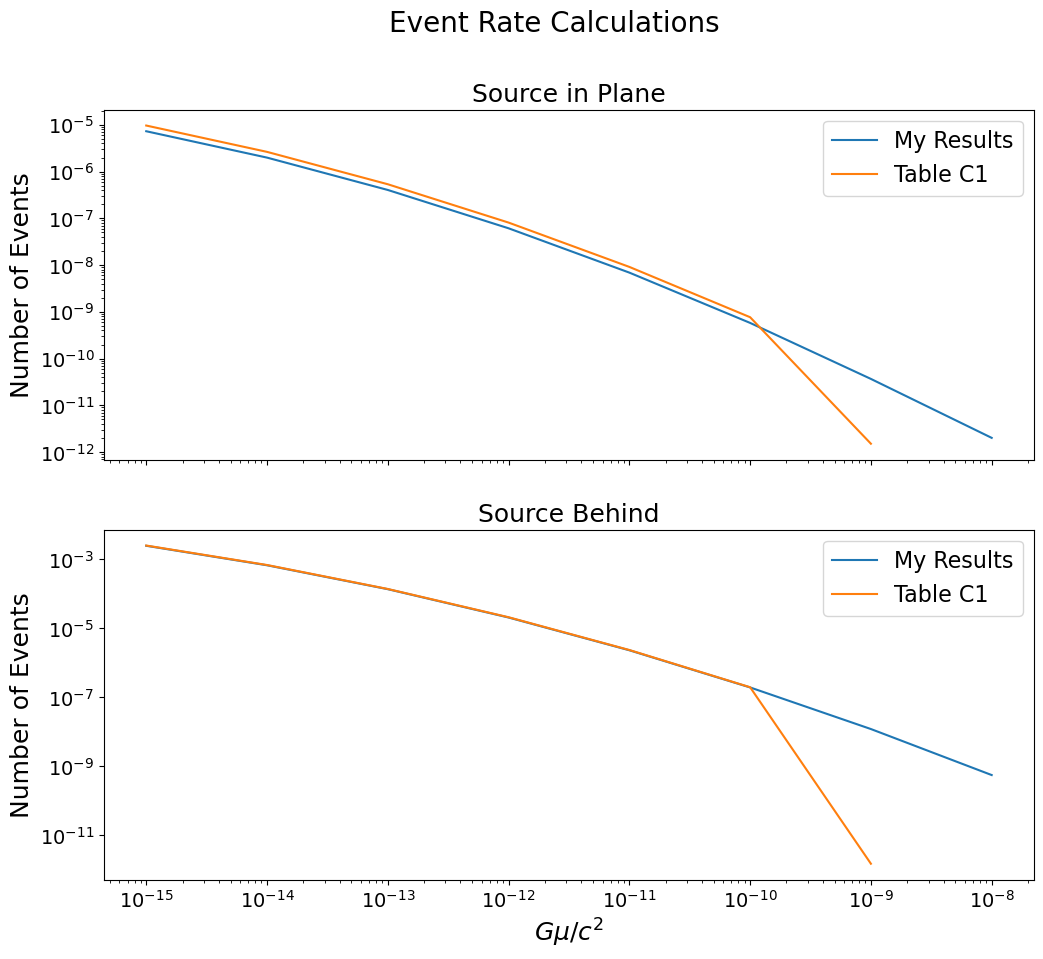

In [9]:
nEventsPlanar = (planarEventCalculator.results["eventRates"] * tObs).decompose()
nEventsBehind = (behindEventCalculator.results["eventRates"] * tObs).decompose()

fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ys = [[nEventsPlanar, tableC1PlanarResults],
      [nEventsBehind, tableC1BackResults]]
labels = ["My Results", "Table C1"]
titles = ["Source in Plane", "Source Behind"]
for iax, (ax, t) in enumerate(zip(axs.ravel(), titles)):
    ax.set_title(t, fontsize=18)
    ax.set_ylabel("Number of Events", fontsize=18)
    ax.tick_params(labelsize=14)
    for y, l, t in zip(ys[iax], labels, titles):
        ax.loglog(planarEventCalculator.tensions, y, label=l)
    ax.legend(fontsize=16)
axs[1].set_xlabel(r"$G\mu/c^2$", fontsize=18)
fig.suptitle("Event Rate Calculations", fontsize=20)
plt.show(fig)

/Users/adrianshestakov/Work/stringScratch/utils/stringUtils.py:378: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend(fontsize=14)


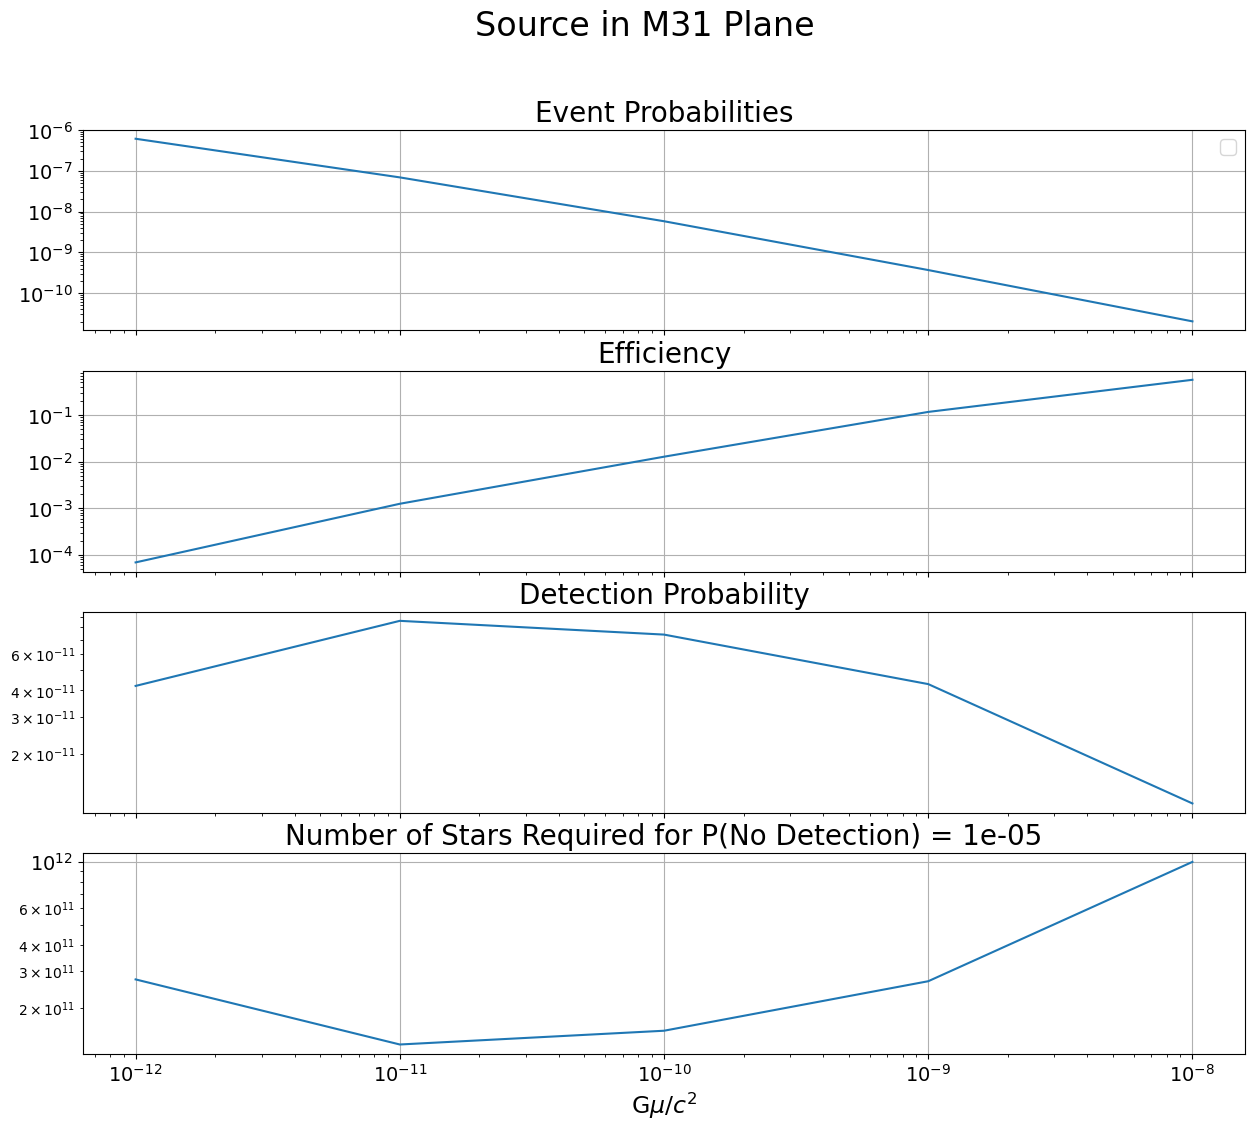

In [10]:
planarExperimentParameters = dict(observingHoursPerNight = 10 * u.hr,
                                  surveyFootprint = 3.167 * u.deg**2)
planarExperimentCalculator = ExperimentExpectationsCalculator(planarExperimentParameters,
                                                              planarEventCalculator)
planarExperimentCalculator.calculate()
planarExperimentCalculator.plotResults(title="Source in M31 Plane")

ngc-300 Mass from [this paper](https://arxiv.org/pdf/1009.0317.pdf)

In [11]:
tensions = np.logspace(-15, -8, num=8)
nSteps = int(1e5)
lmcSkyCoordinates = [49.97 * u.kpc, SkyCoord("05h23m34s", "−69d45.4m")]
ngc300SkyCoordinates = [1.86 * u.Mpc, SkyCoord("00h54m53.5s", "−37d41m04s")]

impactParameter = 0.1 * u.kpc
lmcSourceSkyCoordinates = EventCalculator.relationalPositionToSkyCoordinates(lmcSkyCoordinates,
                                                                             8 * u.kpc, "behind", 
                                                                             impactParameter)
ngc300SourceSkyCoordinates = EventCalculator.relationalPositionToSkyCoordinates(ngc300SkyCoordinates,
                                                                                8 * u.kpc, "behind",
                                                                                impactParameter)

lmcEventConfig = dict(tensions = tensions,
                      curlyG = 1e4,
                      hostGalaxySkyCoordinates = [49.97 * u.kpc, SkyCoord("05h23m34s", "−69d45.4m")],
                      hostGalaxyMass = 1.38e11 * u.solMass,
                      sourceSkyCoordinates = lmcSourceSkyCoordinates
                      )

ngc300EventConfig = lmcEventConfig.copy()
ngc300EventConfig["hostGalaxySkyCoordinates"] = ngc300SkyCoordinates
ngc300EventConfig["hostGalaxyMass"] = 3.3e10 * u.solMass
ngc300EventConfig["sourceSkyCoordinates"] = ngc300SourceSkyCoordinates

smashEventConfig = lmcEventConfig.copy()

lmcEventCalculator = EventCalculator(lmcEventConfig)
ngc300EventCalculator = EventCalculator(ngc300EventConfig)
smashEventCalculator = EventCalculator(smashEventConfig)

lmcEventCalculator.calculate(nSteps=nSteps)
ngc300EventCalculator.calculate(nSteps=nSteps)
smashEventCalculator.calculate(nSteps=nSteps)

In [14]:
(lmcEventCalculator.results["eventRates"] * 10 * u.yr).decompose()

<Quantity [2.95993258e-01, 8.07759026e-02, 1.64165472e-02, 2.48474497e-03,
           2.80079821e-04, 2.35115802e-05, 1.46987979e-06, 6.84355591e-08]>

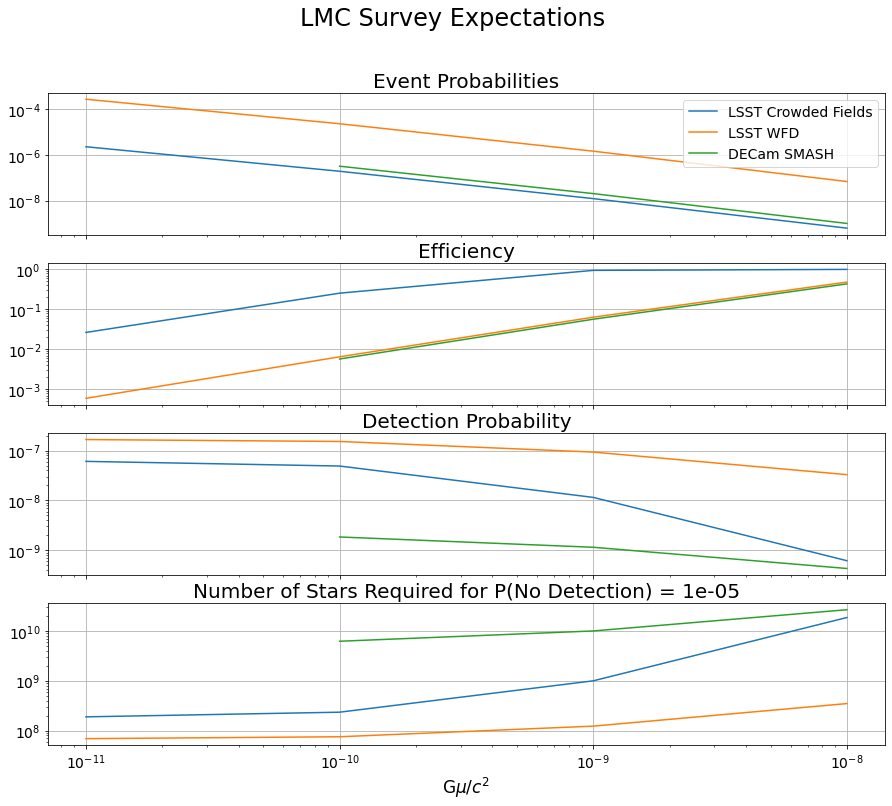

In [9]:
crowdedFieldExperimentConfig = dict(observingHoursPerNight = 4 * u.hr,
                           filters = ["g", "r", "i", "z", "y"],
                           visitsInEachFilter = np.array(5*[60]),
                           experimentDuration = 30 * u.day,
                           surveyFootprint = 40 * u.deg**2
                           )

wfdExperimentConfig = crowdedFieldExperimentConfig.copy()
wfdExperimentConfig["observingHoursPerNight"] = 8 * u.hr
wfdExperimentConfig["surveyFootprint"] = 100 * u.deg**2
wfdExperimentConfig["experimentDuration"] = 10 * u.year
wfdExperimentConfig.pop("visitsInEachFilter")

# ngc300ExperimentConfig = crowdedFieldExperimentConfig.copy()
# ngc300ExperimentConfig["observingHoursPerNight"] = 24 * u.hr
# ngc300ExperimentConfig["surveyFootprint"] = 21.9 * 15.5 * u.arcmin**2

smashExperimentConfig = dict(observingHoursPerNight = 10 * u.hr,
                             filters = ["u", "g", "r", "i", "z"],
                             visitsInEachFilter = np.array(5*[2]),
                             experimentDuration = 50 * u.day,
                             surveyFootprint = 40 * u.deg**2,
                             exposureTime = 60 * u.s
                             )

crowdedFieldExperimentCalculator = ExperimentExpectationsCalculator(crowdedFieldExperimentConfig, 
                                                                    lmcEventCalculator)
# ngc300ExperimentCalculator = ExperimentExpectationsCalculator(ngc300ExperimentConfig, ngc300EventCalculator)
smashExperimentCalculator = ExperimentExpectationsCalculator(smashExperimentConfig, smashEventCalculator)
wfdExperimentCalculator = ExperimentExpectationsCalculator(wfdExperimentConfig, lmcEventCalculator)

crowdedFieldExperimentCalculator.calculate()
# ngc300ExperimentCalculator.calculate()
smashExperimentCalculator.calculate()
wfdExperimentCalculator.calculate()

fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

crowdedFieldExperimentCalculator.plotResults(figure=fig, show=False, label="LSST Crowded Fields",
                                    title="LMC Survey Expectations")
wfdExperimentCalculator.plotResults(figure=fig, show=False, label="LSST WFD")
# ngc300ExperimentCalculator.plotResults(figure=fig, label="NGC 300")
smashExperimentCalculator.plotResults(figure=fig, label="DECam SMASH")

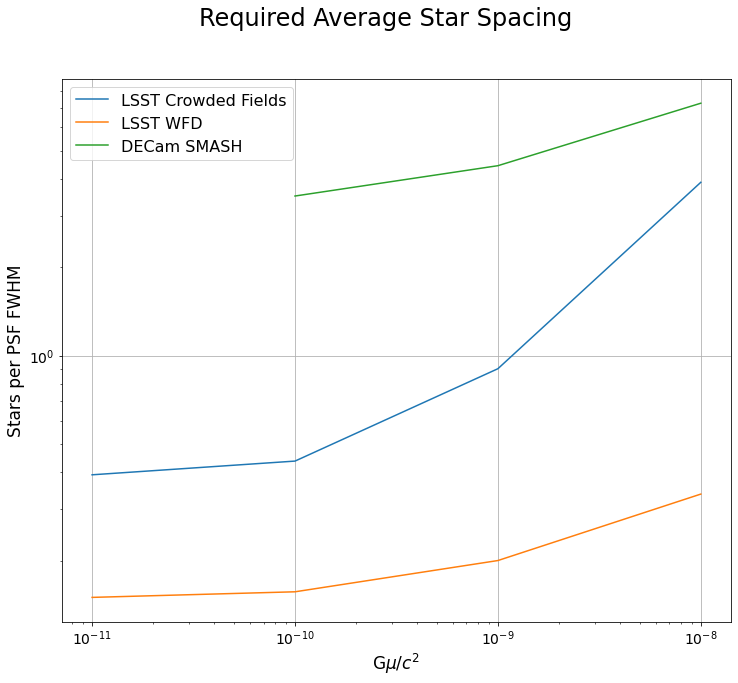

In [10]:
lsstFWHM = 0.65 * u.arcsec
smashFWHM = 1.01 * u.arcsec
fig, ax = plt.subplots(figsize=(12, 10))
crowdedFieldExperimentCalculator.plotStarsPerPSF(lsstFWHM, figure=fig, show=False,
                                                 label="LSST Crowded Fields", 
                                                 title="Required Average Star Spacing")
wfdExperimentCalculator.plotStarsPerPSF(lsstFWHM, figure=fig, show=False,
                                        label="LSST WFD")
# ngc300ExperimentCalculator.plotStarsPerPSF(lsstFWHM, figure=fig, label="NGC 300")
smashExperimentCalculator.plotStarsPerPSF(smashFWHM, figure=fig, label="DECam SMASH")

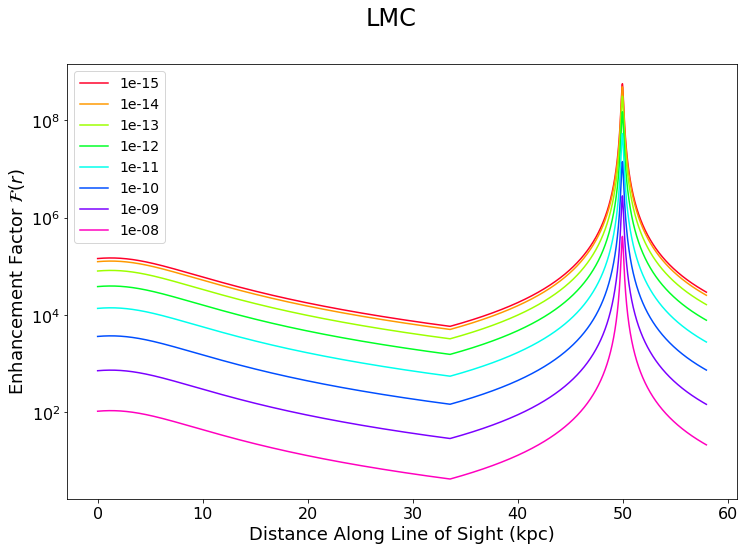

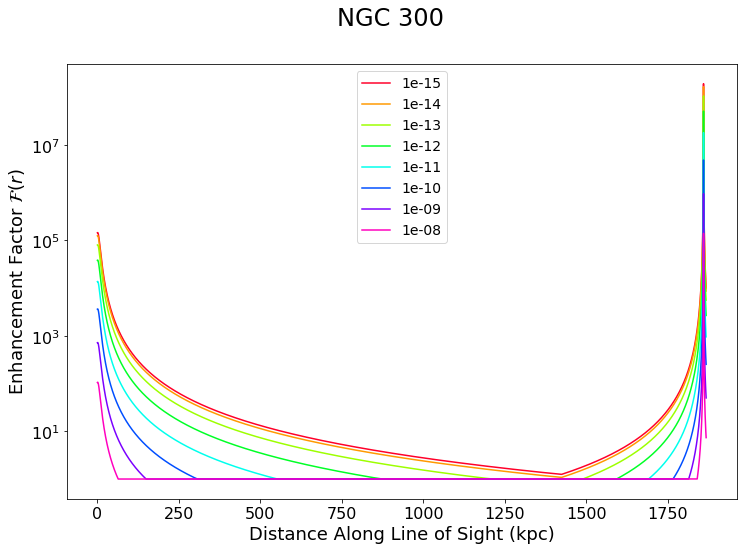

In [11]:
lmcEventCalculator.plotEnhancement(title="LMC")
ngc300EventCalculator.plotEnhancement(title="NGC 300")

In [15]:
lmcLensingTimeCDF, lmcLensingTimeBins = lmcEventCalculator.computeLensingTimeCDF()
lmcMaxTimes = lmcEventCalculator.computeMaximumLensingTimes()

ngc300LensingTimeCDF, ngc300LensingTimeBins = ngc300EventCalculator.computeLensingTimeCDF()
ngc300MaxTimes = ngc300EventCalculator.computeMaximumLensingTimes()

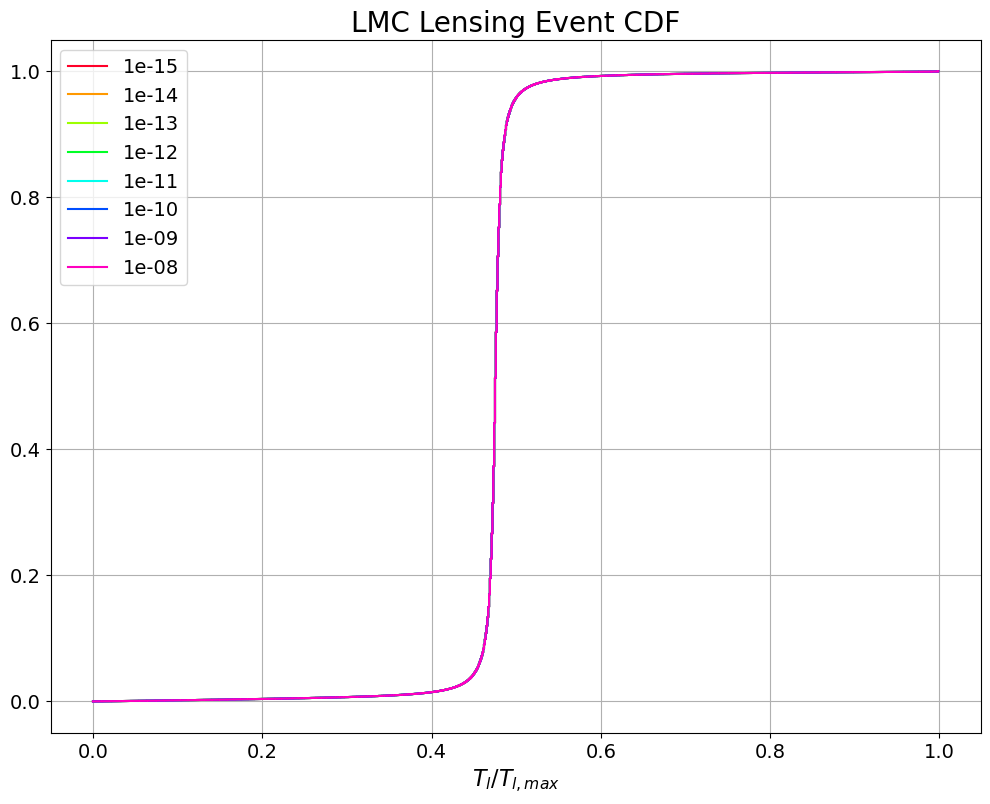

In [16]:
colors = cm.gist_rainbow(np.linspace(0, 1, num=len(lmcEventCalculator.tensions)))

fig, ax = plt.subplots(figsize=(12, 9))

for i in range(len(lmcLensingTimeCDF)):
    ax.plot(lmcLensingTimeBins[i][:-1]/lmcMaxTimes[i], lmcLensingTimeCDF[i], 
            label=f"{lmcEventCalculator.tensions[i]}", color=colors[i], ds="steps-post")
    
ax.tick_params(labelsize=14)
ax.set_xlabel(r"$T_l/T_{l, max}$", fontsize=16)
ax.legend(loc="upper left", fontsize=14)
ax.set_title("LMC Lensing Event CDF", fontsize=20)
ax.grid(visible=True)
plt.show(fig)

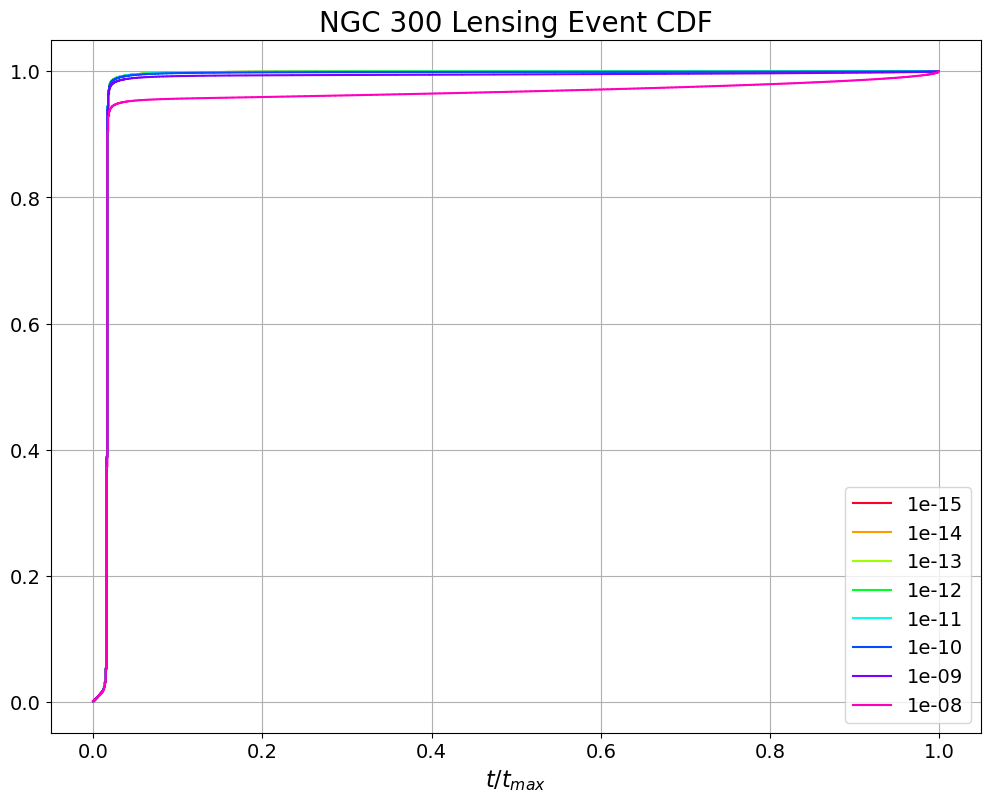

In [17]:
colors = cm.gist_rainbow(np.linspace(0, 1, num=len(ngc300EventCalculator.tensions)))

fig, ax = plt.subplots(figsize=(12, 9))

for i in range(len(ngc300LensingTimeCDF)):
    ax.plot(ngc300LensingTimeBins[i][:-1]/ngc300MaxTimes[i], ngc300LensingTimeCDF[i], 
            label=f"{ngc300EventCalculator.tensions[i]}", color=colors[i], ds="steps-post")
    
ax.tick_params(labelsize=14)
ax.set_xlabel(r"$t/t_{max}$", fontsize=16)
ax.legend(loc="lower right", fontsize=14)
ax.set_title("NGC 300 Lensing Event CDF", fontsize=20)
ax.grid(visible=True)
plt.show(fig)

In [15]:
distanceFromLmcCenter = np.sqrt(2400/2) * u.deg.to(u.rad) * 49.97 * u.kpc
lmcPlanarSkyCoordinates = EventCalculator.relationalPositionToSkyCoordinates(lmcSkyCoordinates,
                                                                             distanceFromLmcCenter, "plane", 
                                                                             impactParameter)

lmcPlanarEventConfig = dict(tensions = tensions,
                            curlyG = 1e4,
                            hostGalaxySkyCoordinates = [49.97 * u.kpc, SkyCoord("05h23m34s", "−69d45.4m")],
                            hostGalaxyMass = 1.38e11 * u.solMass,
                            sourceSkyCoordinates = lmcPlanarSkyCoordinates
                            )

lmcPlanarEventCalculator = EventCalculator(lmcPlanarEventConfig)
lmcPlanarEventCalculator.calculate()

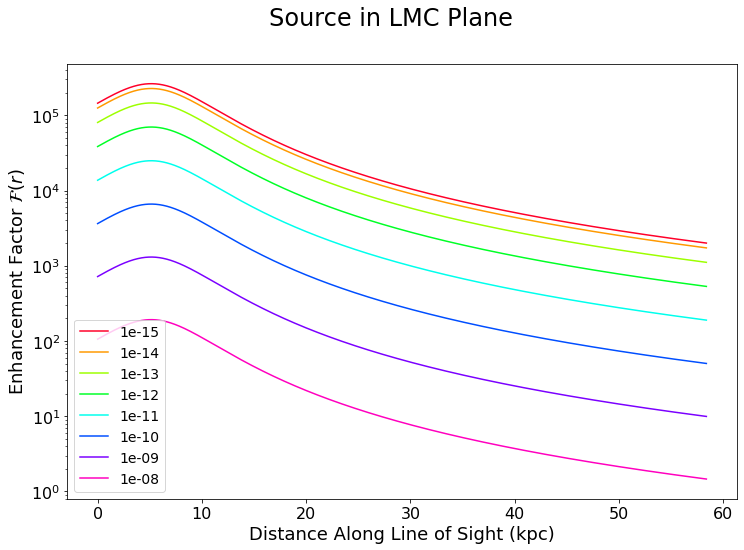

In [16]:
lmcPlanarEventCalculator.plotEnhancement(title="Source in LMC Plane")

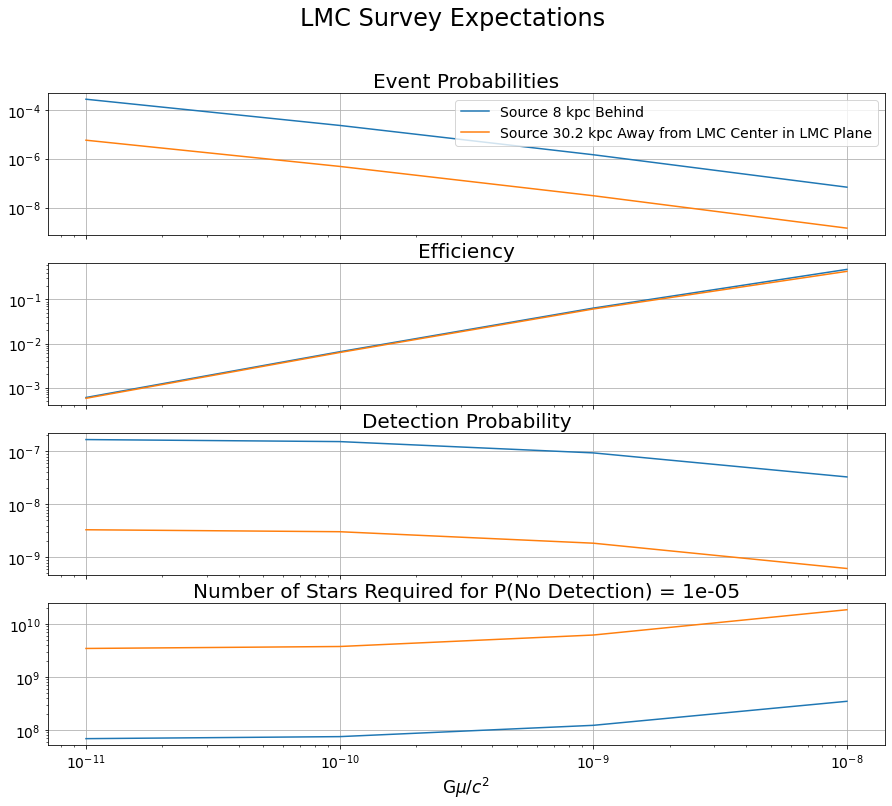

In [17]:
lmcPlanarExperimentCalculator = ExperimentExpectationsCalculator(wfdExperimentConfig, 
                                                                 lmcPlanarEventCalculator)

lmcPlanarExperimentCalculator.calculate()

fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
wfdExperimentCalculator.plotResults(figure=fig, show=False, label="Source 8 kpc Behind",
                                    title="LMC Survey Expectations")
lmcPlanarLabel = f"Source {distanceFromLmcCenter:.1f} Away from LMC Center in LMC Plane"
lmcPlanarExperimentCalculator.plotResults(figure=fig, label=lmcPlanarLabel)